# Analysis of gender distribution in UK's leading newspapers
# Gender topics

## Content
1. [Setup](#setup)   
    1.1 [Global](#global_setup)  
    1.2 [Local](#local_setup)   
2. [Time statistic](#time_statistic)   
    2.1 [Functions](#functions)  
    2.2 [Create statistic](#statistic)    
    2.3 [Plots](#plots) 

## 1. Setup
<a id="setup"></a>

### 1.1 Global
<a id="global_setup"></a>

In [1]:
# Change to true if you want to use google colab
use_colab = True

# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive._mount('/content/drive', force_remount=True)
    %cd /content/drive/Shareddrives/ADA-project
    !pip install pandas==1.0.5 # downgrade pandas for chunk processing support

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


In [2]:
# Defined paths for the data
from scripts.path_defs import *

# Defined newspapers and urls
from scripts.newspapers import *

# Globally used functions
from scripts.utility_functions import load_mini_version_of_data
from scripts.utility_functions import convert_to_1Dseries
from scripts.utility_functions import process_data_in_chunks

### 1.2 Local 
<a id="local_setup"></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import bz2

## 2. Time statistic
<a id="time_statistic"></a>

### 2.1 Functions
<a id="functions"></a>

In [4]:
def group_genders(x):
    if len(x)==1:
        if x[0] in ['male', 'female']:
            return x[0]
        else:
            return 'other'
    else:
        return 'other'

def get_gender_counts(chunk, gender_repr_df, year):
    for newspaper in newspapers_uk_df['name']:
        cols = ['year', 'gender', 'newspaper', 'count']
        mask_newspaper = chunk.newspapers.apply(lambda x: newspaper in x)
        newspaper_df = chunk[mask_newspaper]
        genders_grouped = newspaper_df.gender.apply(group_genders)
    
        counts_males = (genders_grouped == 'male').sum()
        counts_females = (genders_grouped == 'female').sum()
        counts_others = (genders_grouped == 'other').sum()

        gender_repr_df = gender_repr_df.append(pd.DataFrame([[year, 'male', newspaper, counts_males]], columns=cols), ignore_index = True)
        gender_repr_df = gender_repr_df.append(pd.DataFrame([[year, 'female', newspaper, counts_females]], columns=cols), ignore_index = True)
        gender_repr_df = gender_repr_df.append(pd.DataFrame([[year, 'other', newspaper, counts_others]], columns=cols), ignore_index = True)
     
    gender_repr_df = gender_repr_df.groupby(['year','gender', 'newspaper']).sum().reset_index()
    return gender_repr_df

### 2.2 Create statistic
<a id="statistic"></a>

In [5]:
# Dataframe of newspapers
newspapers_uk_df = pd.DataFrame(newspapers_uk_list, columns = ['name', 'website_url'])
newspapers_uk_df.head(14)

,name,website_url
0,The Sun,thesun.co.uk
1,The Guardian,theguardian.com
2,The Times,thetimes.co.uk
3,Metro,metro.co.uk
4,Evening Standard,standard.co.uk
5,Daily Mirror,mirror.co.uk
6,The Daily Telegraph,telegraph.co.uk
7,Daily Express,express.co.uk
8,Daily Star,dailystar.co.uk
9,i,inews.co.uk


In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
gender_repr_df = pd.DataFrame(columns=['year', 'newspaper', 'gender', 'count'])

for year in years:
    path_to_file = globals()['MERGED_QUOTES_' + str(year) + '_PATH']
    gender_repr_df = process_data_in_chunks(path_to_file, get_gender_counts, gender_repr_df, year, use_colab)
    print(str(year) + ' finished')

In [ ]:
# Add a frequency column
gender_repr_df['sum'] = gender_repr_df.groupby(['year', 'newspaper'])['count'].transform('sum')
gender_repr_df['frequency'] = gender_repr_df['count'] / gender_repr_df['sum']
gender_repr_df.drop('sum', axis=1, inplace=True)

In [29]:
# Save results as pickle
gender_repr_df.to_pickle(GENDER_REPRESENTATION_2015_TO_2020_UK_PATH)

### 2.3 Plots
<a id="plots"></a>

In [31]:
# Load from Results folder
gender_repr_df = pd.read_pickle(GENDER_REPRESENTATION_2015_TO_2020_UK_PATH)
gender_repr_df.head()

,year,gender,newspaper,count,frequency
0,2015,female,City A.M.,711,0.103705
1,2015,female,Daily Express,9880,0.183585
2,2015,female,Daily Mail,1597,0.155094
3,2015,female,Daily Mirror,14324,0.243668
4,2015,female,Daily Record,6548,0.243104


In [9]:
# Set index and sort
gender_repr_df.set_index(['year'], inplace=True)
gender_repr_df.sort_index(inplace=True)

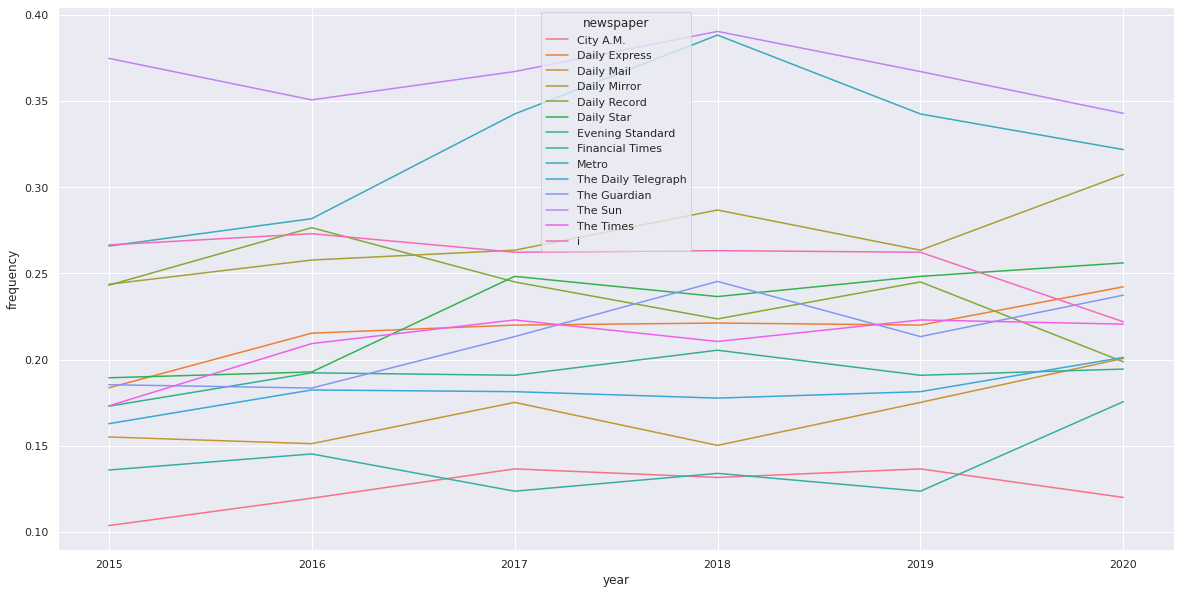

In [40]:
female_quotes = gender_repr_df.loc[gender_repr_df['gender'] == 'female']
female_quotes.head(20)

sns.set(rc={"figure.figsize":(20, 10)})
sns.lineplot(data=female_quotes.reset_index(), x='year', y='frequency', hue='newspaper')